In [1]:
%matplotlib notebook

In [2]:
## importing database
from thinc.extra.datasets import imdb
imdb_data = imdb()

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
## Define constants
maxlen = 500 # cutoff text for a max of 100 words
max_words = 10000 # consider only the top 10k words of the database
training_samples = 10000
validation_samples = 1000

In [6]:
texts = [d for d in zip(*imdb_data[0])][0]
labels = [d for d in zip(*imdb_data[0])][1]

In [7]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [8]:
word_index = tokenizer.word_index
index_word = { v:k for k,v in word_index.items()} ## just for testing

In [9]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

In [10]:
print(data.min(),data.max())
print(min(np.concatenate(sequences)),max(np.concatenate(sequences)))

0 9999
1 9999


In [67]:
## [{v:k for k,v in word_index.items()}.get(i) for i in data[99] ]

In [11]:
import os
glove_dir = "/home/omar/Documents/DataScience/TextML/embeddings"

embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype = 'float32')
    except ValueError:
        print(values[1:])
    embeddings_index[word] = coefs
f.close()
print('Found %d word vectors'%len(embeddings_index))

Found 400000 word vectors


In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        #else:
        #    print('%s is not in the embedded matrix'%word)

In [13]:
print(embedding_matrix[0,:5])
print(embedding_matrix[10000-1,:5])

[0. 0. 0. 0. 0.]
[-0.51964003  0.017001   -0.19586    -0.62606001 -0.47911999]


## Training the NN

In [20]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

### Using the Embedded layer with a regular Multilayer NN

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [18]:
model = Sequential()
model.add(Embedding(max_words,
                    embedding_dim,
                    input_length=maxlen,
                    trainable = False, 
                    weights = [embedding_matrix]))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,600,065
Trainable params: 1,600,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data=(x_val,y_val),
                    verbose=False)

In [27]:
# model.save_weights('pre_trained_glove_model.h5')

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1,len(acc)+1)

<IPython.core.display.Javascript object>


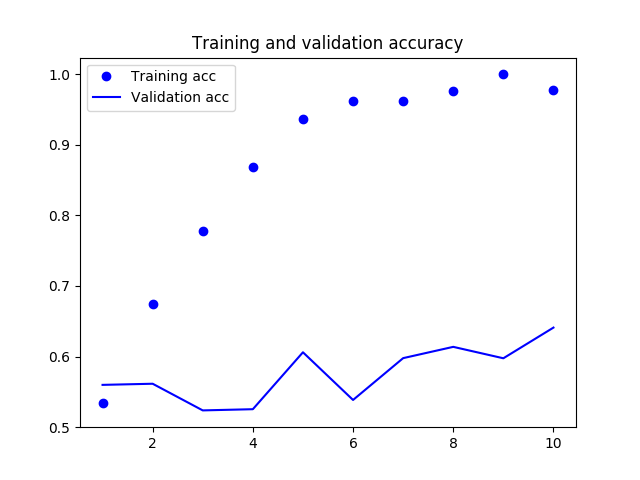

In [24]:
plt.figure()
plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### with SimpleRNN

In [26]:
from keras.layers import Dense, SimpleRNN

In [42]:
model_rnn = Sequential()
model_rnn.add(Embedding(max_words,
                        embedding_dim,
                        input_length=maxlen,
                        trainable = False,
                        weights = [embedding_matrix]))
#model_rnn.add(Embedding(max_words,32))
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,004,289
Trainable params: 4,289
Non-trainable params: 1,000,000
_________________________________________________________________


In [43]:
model_rnn.compile(optimizer='rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])

history_rnn = model_rnn.fit(x_train,
                            y_train,
                            epochs = 10,
                            batch_size = 128,
                            validation_data=(x_val,y_val),
                            verbose=False)

<IPython.core.display.Javascript object>


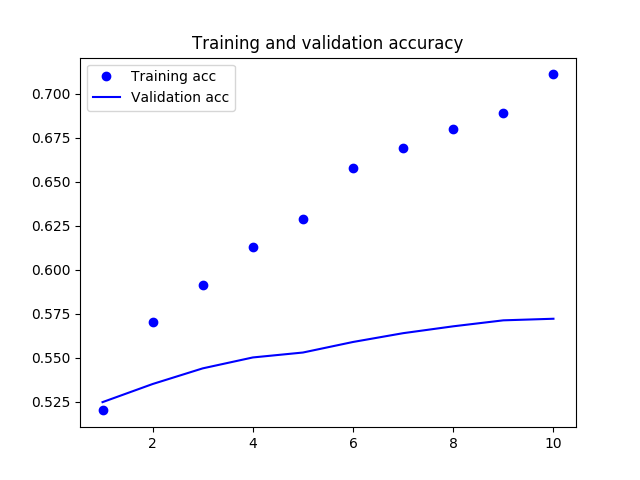

In [45]:
acc = history_rnn.history['acc']
val_acc = history_rnn.history['val_acc']
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
epochs = np.arange(1,len(acc)+1)

plt.figure()
plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

<IPython.core.display.Javascript object>


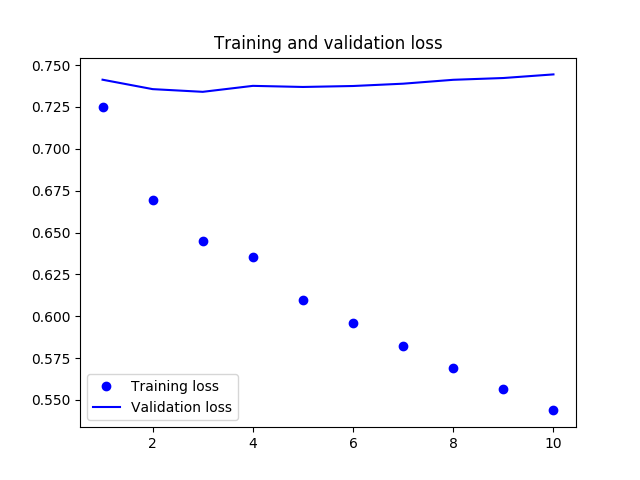

In [154]:
plt.figure()
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [46]:
print(acc)
print(val_acc)

[0.5200000014305115, 0.5699999971389771, 0.5910000014305115, 0.6130000023841858, 0.6289999976158142, 0.6580000019073486, 0.6689999985694886, 0.6799999976158142, 0.6890000004768372, 0.7109999980926514]
[0.5247, 0.535, 0.5439, 0.5501, 0.5529, 0.5589, 0.5639, 0.5678, 0.5712, 0.5721]


### with LSTM

In [25]:
## Define constants
maxlen = 500 # cutoff text for a max of 100 words
max_words = 10000 # consider only the top 10k words of the database
training_samples = 10000
validation_samples = 1000
test_samples = 1000

## training data preparation
x_train =   data[:training_samples]
y_train = labels[:training_samples]

x_val =   data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

x_test =   data[training_samples+validation_samples:training_samples+validation_samples+test_samples]
y_test = labels[training_samples+validation_samples:training_samples+validation_samples+test_samples]

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional,TimeDistributed, Dense

In [19]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words,
                         embedding_dim,
                         input_length=maxlen,
                         trainable = False,
                         weights = [embedding_matrix]))

#model_lstm.add(Embedding(max_words,32))
model_lstm.add(TimeDistributed(Dense(64, use_bias=False)))
model_lstm.add(Bidirectional(LSTM(64,dropout = 0.1,recurrent_dropout=0.5)))
#model_lstm.add(LSTM(32))
model_lstm.add(Dense(1,activation='sigmoid'))
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 64)           6400      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,072,577
Trainable params: 72,577
Non-trainable params: 1,000,000
_________________________________________________________________


In [22]:
model_lstm.compile(optimizer='rmsprop',
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])

history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs = 10,
                              batch_size = 128,
                              validation_data=(x_val,y_val),
                              verbose=False)

In [23]:
acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = np.arange(1,len(acc)+1)
print(('val_acc = %0.2f, val_loss = %0.2f ')%(max(val_acc),min(val_loss)))
## with embeded learned from db, Bidirectional(LSTM(32)): val_acc = 0.69, val_loss = 0.60
## with embeded learned from db, Bidirectional(LSTM(32)), trainable = True: val_acc = 0.72, val_loss = 0.55
## with random embedded, Bidirectional(LSTM(32)): val_acc = 0.76, val_loss = 0.52, val_acc = 0.77, val_loss = 0.49
## Last one with the TimeDistributed layer with 32 hidden: val_acc = 0.64, val_loss = 0.63
## Last one with the TimeDistributed layer with 64 hidden: val_acc = 0.67, val_loss = 0.62
## Adding more train points (~10k) and doing trainable = False: val_acc = 0.83, val_loss = 0.38 

val_acc = 0.83, val_loss = 0.38 


<IPython.core.display.Javascript object>


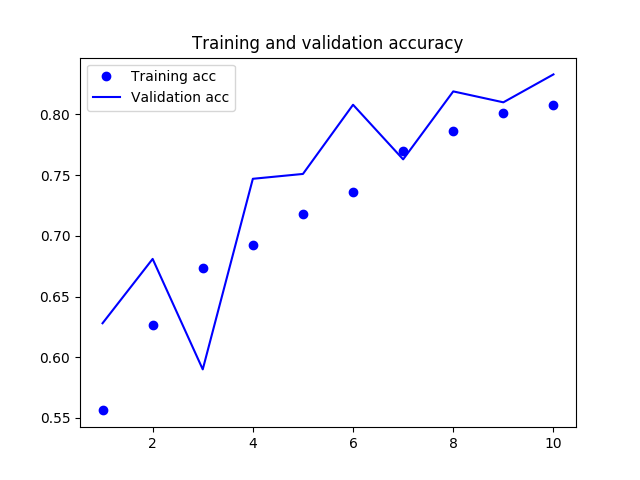

<IPython.core.display.Javascript object>


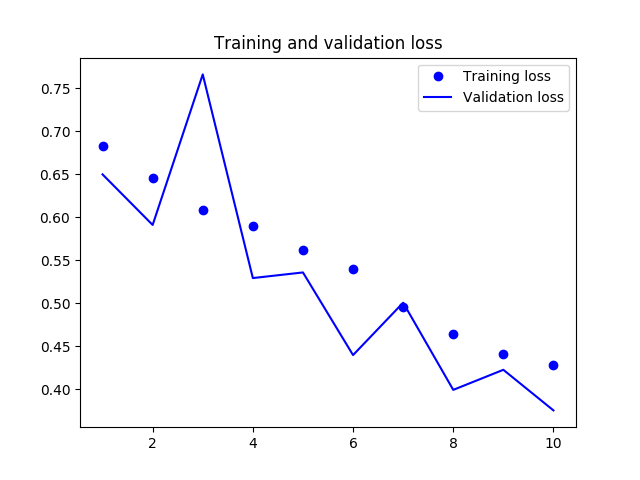

In [24]:
plt.figure()
plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [36]:
from sklearn.metrics import confusion_matrix

In [29]:
y_test_hat = model_lstm.predict_classes(x_test)

In [37]:
#sum([ bool(y) and bool(yh) for y,yh in zip(y_test,y_test_hat)]) / y_test.shape[0]
confusion_matrix(y_test,y_test_hat)

array([[431,  70],
       [116, 383]])

In [38]:
(383 + 431)/1000

0.814

### with GRU

In [53]:
from keras.layers import GRU, Flatten, Dropout

In [183]:
model_gru = Sequential()
model_gru.add(Embedding(max_words,
                        embedding_dim,
                        input_length=maxlen,
                        trainable = False,
                        weights = [embedding_matrix],
                        mask_zero = True))
model_gru.add(TimeDistributed(Dense(32, use_bias=False)))
model_gru.add(Bidirectional(GRU(32,
                                dropout = 0.1,
                                recurrent_dropout=0.5,
                                return_sequences=False,
                                use_bias=True)))
#model_gru.add(Dropout(0.5))
#model_gru.add(TimeDistributed(Dense(1,activation='relu',use_bias=False))) ##
model_gru.add(Dense(1,activation='sigmoid', use_bias=True)) ##
#model_gru.add(Flatten())
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
time_distributed_46 (TimeDis (None, 500, 32)           3200      
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 64)                12480     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 65        
Total params: 1,015,745
Trainable params: 15,745
Non-trainable params: 1,000,000
_________________________________________________________________


In [184]:
model_gru.compile(optimizer='rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

In [185]:
history_gru = model_gru.fit(x_train,
                            y_train,
                            epochs = 10,
                            batch_size = 128,
                            validation_data=(x_val,y_val),
                            verbose=False)

In [186]:
acc = history_gru.history['acc']
val_acc = history_gru.history['val_acc']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
epochs = np.arange(1,len(acc)+1)
print(('val_acc = %0.2f, val_loss = %0.2f ')%(max(val_acc),min(val_loss)))
## Version with Bidirectional(GRU(64,dropout = 0.1,recurrent_dropout=0.5))
## and Dense(1,activation='sigmoid')): val_acc = 0.86, val_loss = 0.35
## Another example version Dist Dense + LSTM => val_acc = 0.83, val_loss = 0.40
## Same that before only changing LSTM by GRU layer => val_acc = 0.84, val_loss = 0.37

val_acc = 0.84, val_loss = 0.37 


<IPython.core.display.Javascript object>


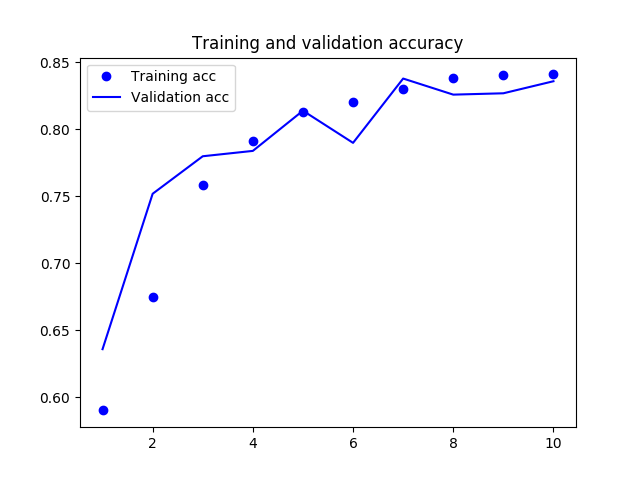

<IPython.core.display.Javascript object>


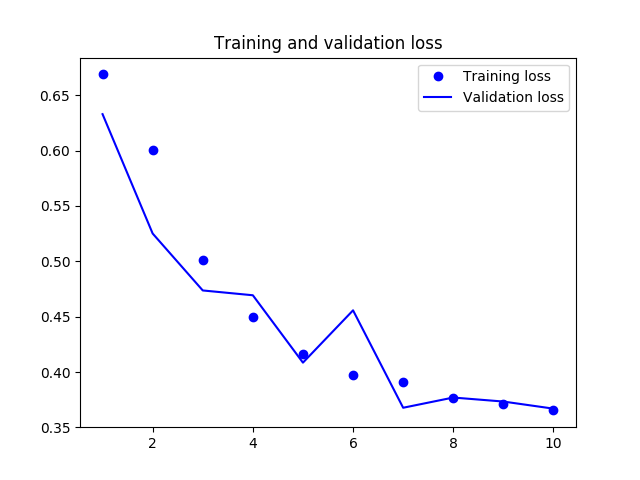

In [187]:
plt.figure()
plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

### BLSTM

In [155]:
# from keras.layers import Merge,Concatenate
from keras.layers.merge import Concatenate,concatenate

In [148]:
model1 = Sequential()
model1.add(Embedding(max_words,
                     embedding_dim,
                     input_length=maxlen,
                     trainable = False,
                     weights = [embedding_matrix]))
model1.add(LSTM(32, return_sequences=True, dropout = 0.1, recurrent_dropout=0.5,))

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(LSTM(32, return_sequences=True, dropout = 0.1, recurrent_dropout=0.5,go_backwards=True))

In [163]:
model_blstm = Sequential()
model_blstm.add(Merge([model1, model2], mode='concat'))
model_blstm.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_blstm.add(Flatten())
model_blstm.add(Dense(1,activation='sigmoid', use_bias=True)) ##
model_blstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_8 (Merge)              (None, 500, 64)           0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 500, 1)            65        
_________________________________________________________________
flatten_16 (Flatten)         (None, 500)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 501       
Total params: 2,034,614
Trainable params: 1,034,614
Non-trainable params: 1,000,000
_________________________________________________________________


/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [158]:
print(concatenate.__doc__)

Functional interface to the `Concatenate` layer.

    # Arguments
        inputs: A list of input tensors (at least 2).
        axis: Concatenation axis.
        **kwargs: Standard layer keyword arguments.

    # Returns
        A tensor, the concatenation of the inputs alongside axis `axis`.
    


In [146]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 500, 32)           17024     
Total params: 1,017,024
Trainable params: 1,017,024
Non-trainable params: 0
_________________________________________________________________
